In [1]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import seaborn as sns
import os
import pickle
import sys
sys.path.append("..")
from tqdm import tqdm
import networkx as nx
from tools.opera_tools import gen_graphx, gen_x_y_dataset, plot_dataframe
from tools.opera_tools import BRICK_X_MAX, BRICK_X_MIN, BRICK_Y_MAX, BRICK_Y_MIN, SAFE_M
import seaborn as sns
sns.set()

In [2]:
import os
import psutil
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, log_loss
from sklearn.metrics import precision_recall_curve
from IPython.display import clear_output
import sys
sys.path.append("..")
from sklearn.linear_model import TheilSenRegressor
from copy import deepcopy      
from collections import Counter
import pandas as pd
EPS = 1e-6

## Чтение данных

In [3]:
import pandas as pd
from tqdm import tqdm_notebook

def digraph_to_csv(graphs: list):
    df = pd.DataFrame(columns=['brick_id', 'shower_id', 'SX', 'SY', 'SZ', 'TX', 'TY'])
    for i, graph in tqdm_notebook(enumerate(graphs)):
        nodes = graph.nodes()
        SX = [node['features']['SX'] for node in nodes.values()]
        SY = [node['features']['SY'] for node in nodes.values()]
        SZ = [node['features']['SZ'] for node in nodes.values()]
        TX = [node['features']['TX'] for node in nodes.values()]
        TY = [node['features']['TY'] for node in nodes.values()]
        shower_id = [node['signal'] for node in nodes.values()]
        brick_id = [i for _ in range(len(shower_id))]
        df = df.append(
            pd.DataFrame(
                {'brick_id': brick_id, 
                 'shower_id': shower_id, 
                 'SX': SX, 
                 'SY': SY, 
                 'SZ': SZ, 
                 'TX': TX, 
                 'TY': TY
                }
            )
        )
    return df
        

def csv_to_digraph(df: pd.DataFrame):
    bricks = []
    for name, group in df.groupby('brick_id'):
        print(group.shape)
        nodes_to_add = []

        for node_id, row in group.iterrows():
            nodes_to_add.append(
                (
                    node_id,
                    {
                        'features': {
                            'SX': row.SX,
                            'SY': row.SY,
                            'SZ': row.SZ,
                            'TX': row.TX,
                            'TY': row.TY,
                        },
                        'signal': row['shower_id']
                    }
                )
            )
        graphx = nx.DiGraph()
        graphx.add_nodes_from(nodes_to_add)
        bricks.append(graphx)
    return bricks

In [4]:
df = np.loadtxt('./data/opera/opera_train.data')
df = pd.DataFrame(df, columns=['brick_id', 'SX', 'SY', 'SZ', 'TX', 'TY'])

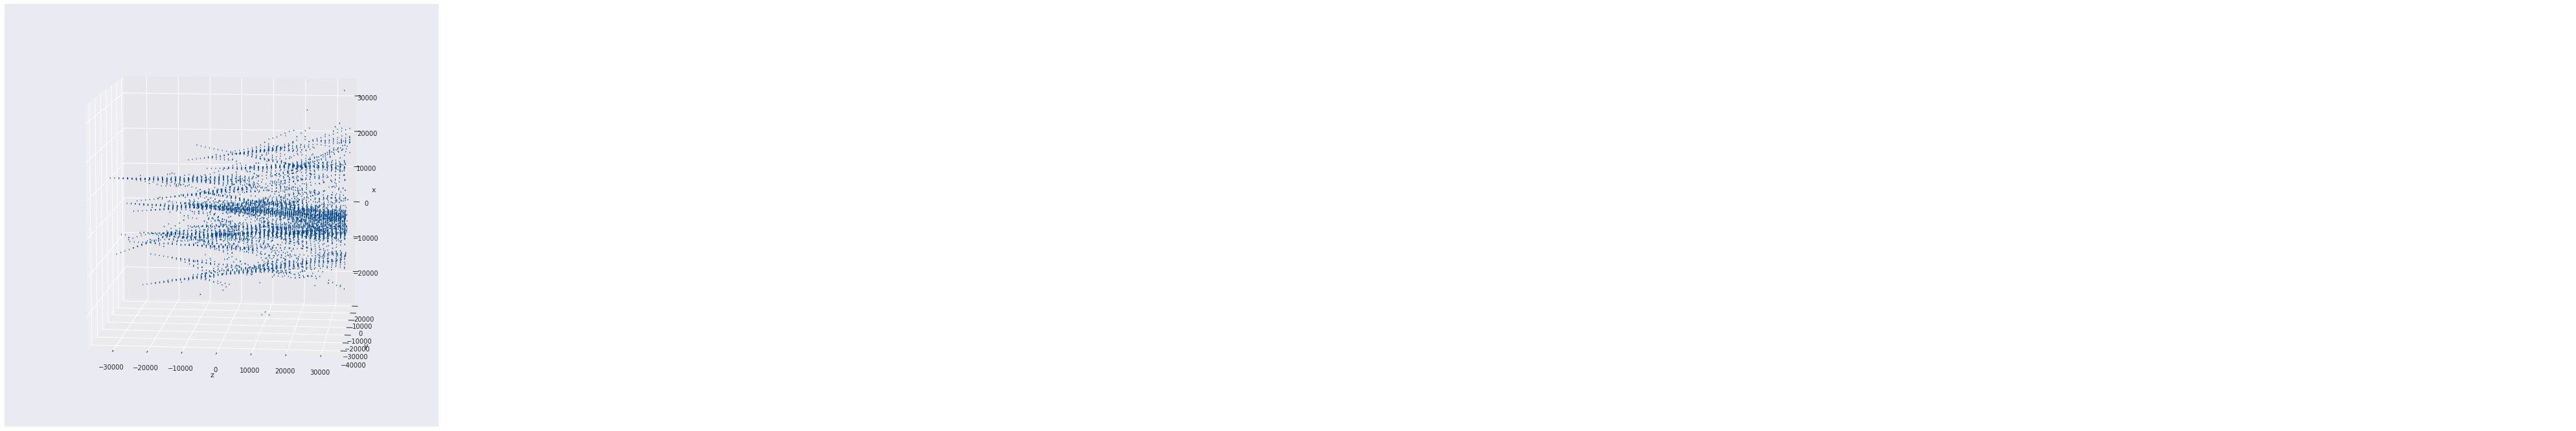

In [5]:
# будьте осторжны! Не подавайте на вход весь датафрейм
plot_dataframe(df.loc[df.brick_id==0])

In [6]:
df_labels = np.loadtxt('./data/opera/opera_train.solution')
df_labels = pd.DataFrame(df_labels, columns=['brick_id', 'shower_id'])

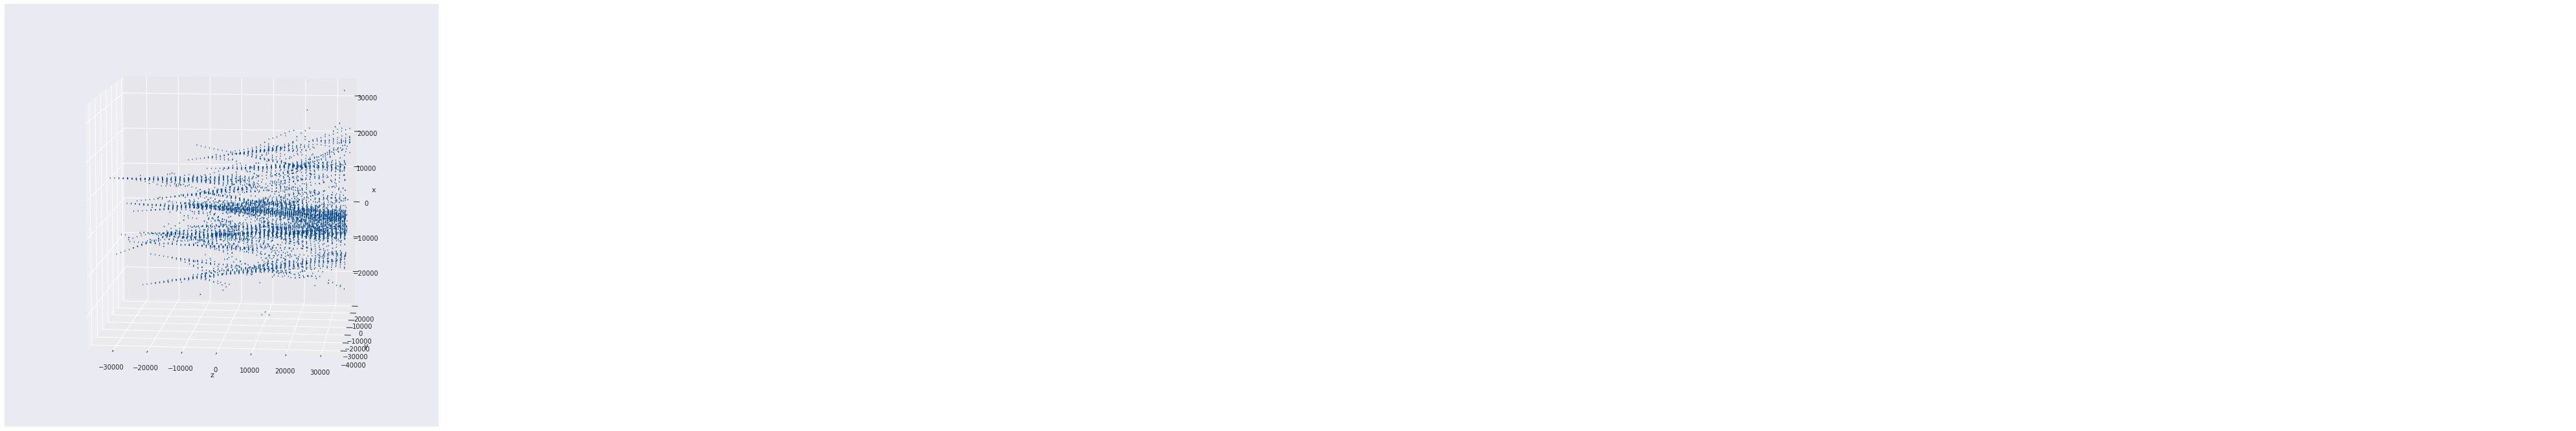

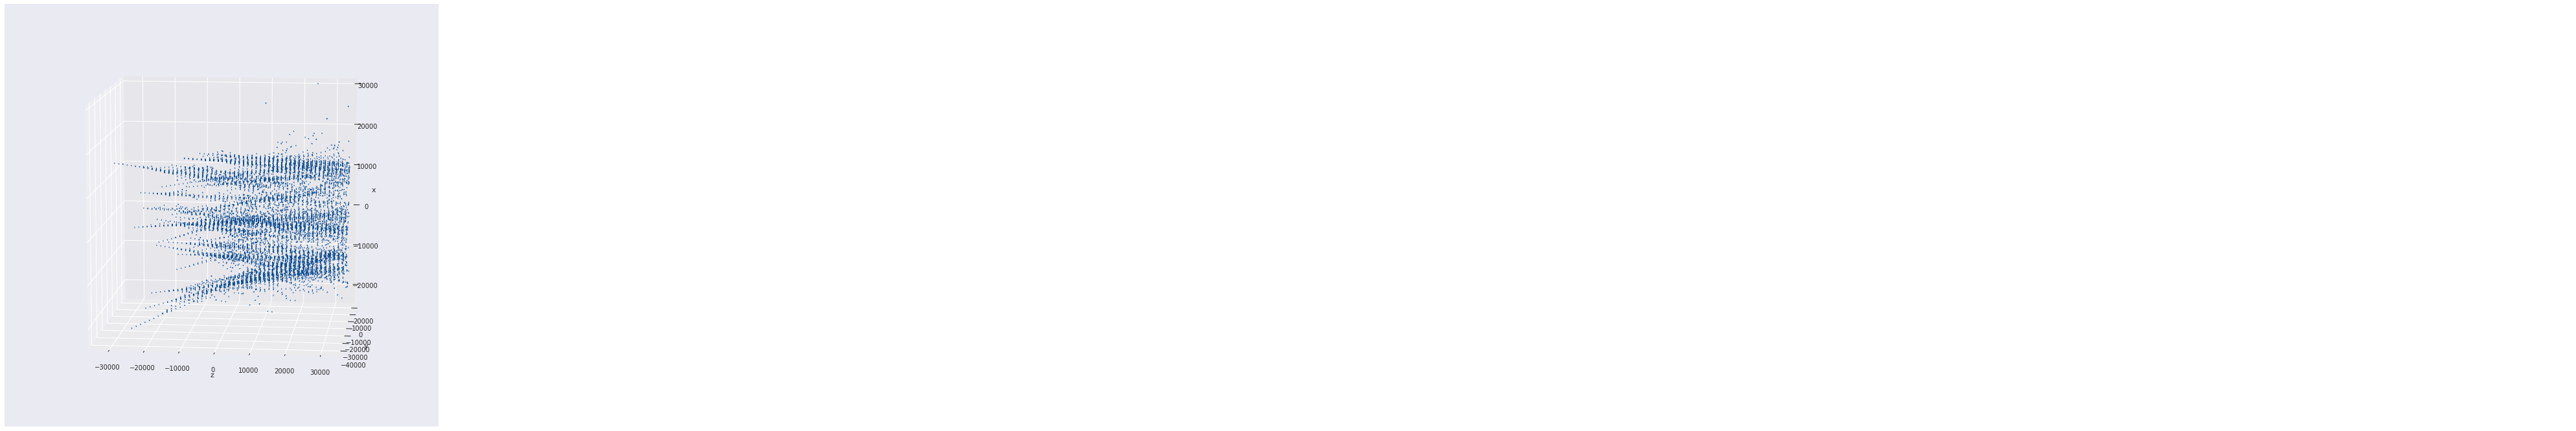

In [7]:
plot_dataframe(df.loc[df.brick_id==0])
plot_dataframe(df.loc[df.brick_id==1])

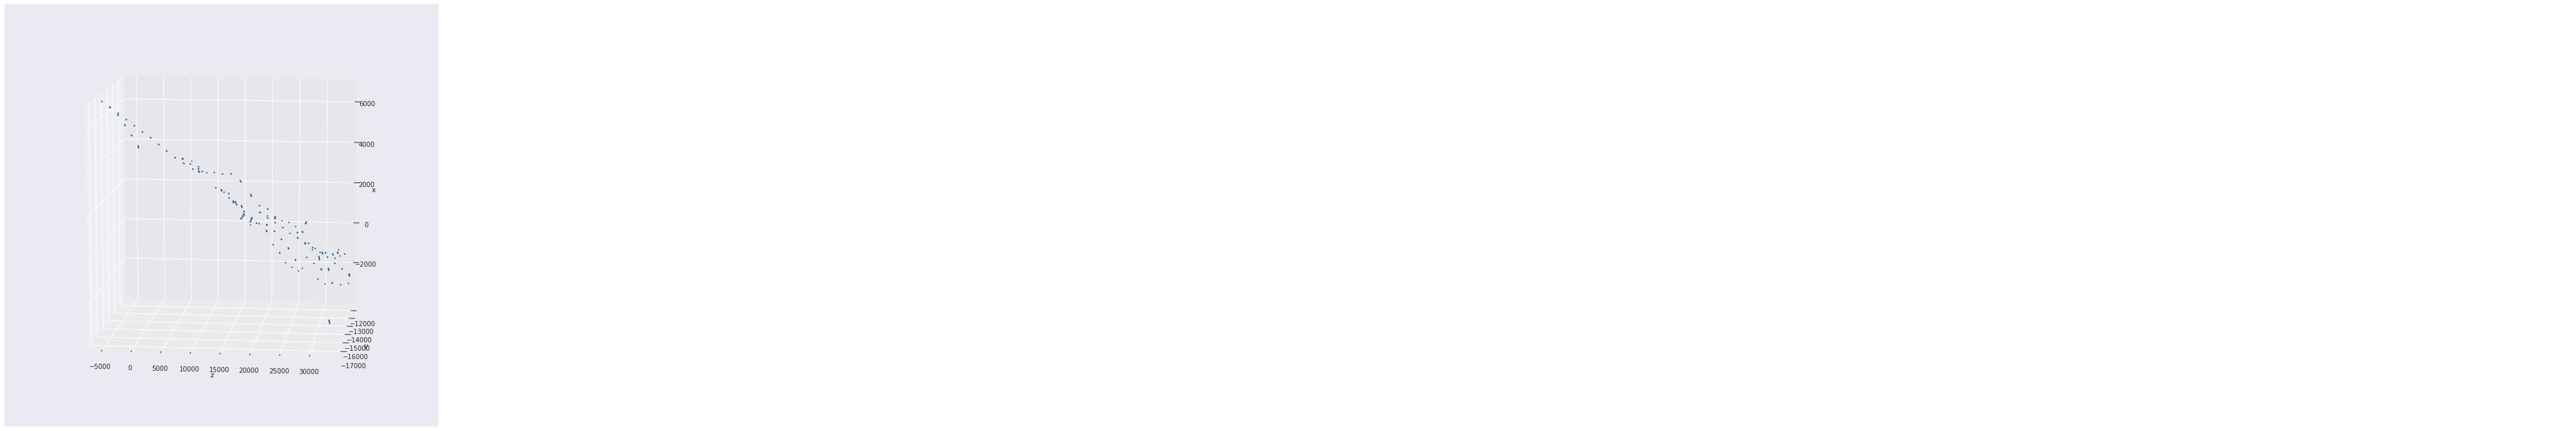

In [8]:
plot_dataframe(df.loc[(df_labels.brick_id==0) & (df_labels.shower_id==2)])

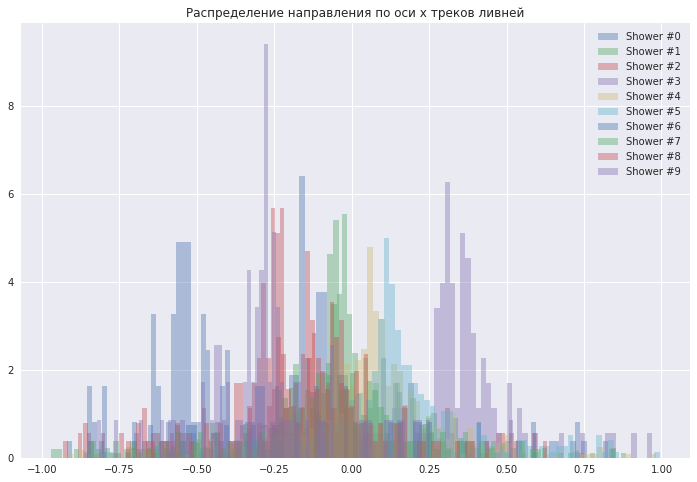

In [17]:
plt.figure(figsize=(12, 8))
plt.title('Распределение \theta_x треков ливней')
for i in range(10):
    plt.hist(df.loc[(df_labels.brick_id==0) & (df_labels.shower_id==i)].TX, 
             density=True, bins=100, label='Shower #{}'.format(i), alpha=0.4)
plt.legend()
plt.show()

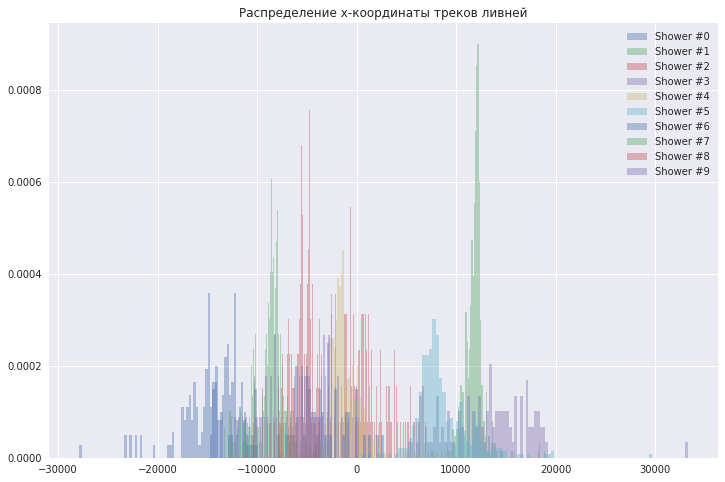

In [18]:
plt.figure(figsize=(12, 8))
plt.title('Распределение x-координаты треков ливней')
for i in range(10):
    plt.hist(df.loc[(df_labels.brick_id==0) & (df_labels.shower_id==i)].SX, 
             density=True, bins=100, label='Shower #{}'.format(i), alpha=0.4)
plt.legend()
plt.show()

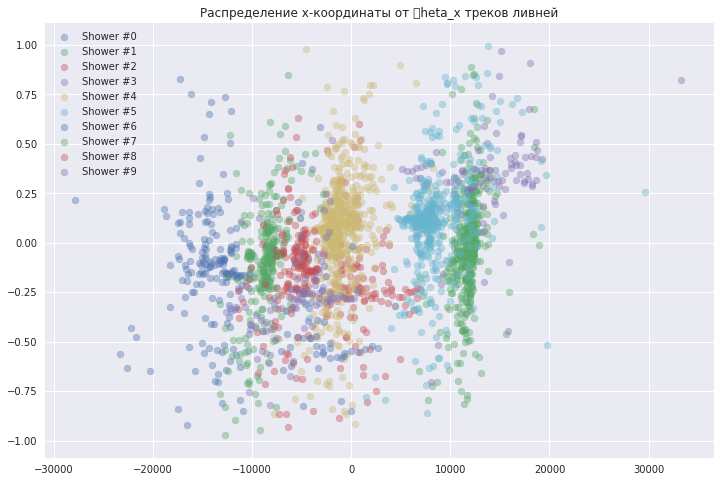

In [20]:
plt.figure(figsize=(12, 8))
plt.title('Распределение x-координаты от \theta_x треков ливней')
for i in range(10):
    plt.scatter(df.loc[(df_labels.brick_id==0) & (df_labels.shower_id==i)].SX, 
                df.loc[(df_labels.brick_id==0) & (df_labels.shower_id==i)].TX,
                label='Shower #{}'.format(i), alpha=0.4)
plt.legend()
plt.show()

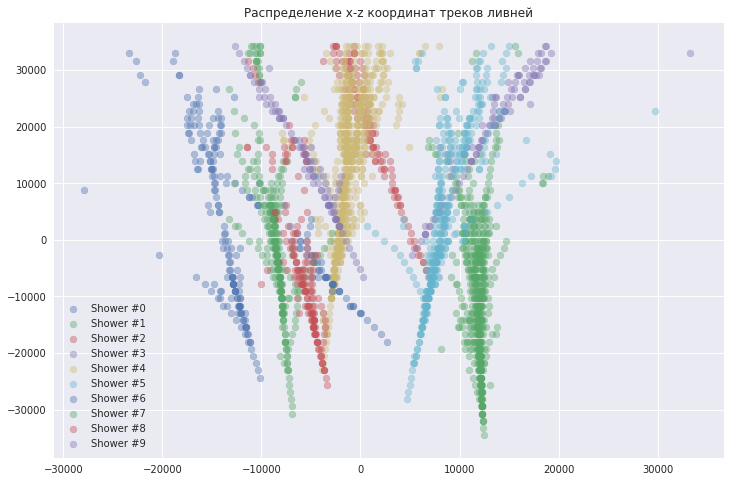

In [24]:
plt.figure(figsize=(12, 8))
plt.title('Распределение x-z координат треков ливней')
for i in range(10):
    plt.scatter(df.loc[(df_labels.brick_id==0) & (df_labels.shower_id==i)].SX, 
                df.loc[(df_labels.brick_id==0) & (df_labels.shower_id==i)].SZ,
                label='Shower #{}'.format(i), alpha=0.4)
plt.legend()
plt.show()

In [ ]:
plot_graphx(bricks[0])

# FYI

Оставь надежду всяк сюда входящий

Данный код может вам пригодиться если вы захотите запустить MPNN.

In [ ]:
from math import fabs, sqrt, log
def rms_integral_root_closed_py(basetrack_left, basetrack_right, 
                             TX_LEFT='TX', TY_LEFT='TY',
                             TX_RIGHT='TX', TY_RIGHT='TY'):
    """
    Метрика близости между двумя треками
    """
    
    dz = basetrack_right['features']['SZ'] - basetrack_left['features']['SZ']
    dx = basetrack_left['features']['SX'] - (basetrack_right['features']['SX'] - basetrack_right['features']['TX'] * dz)
    dy = basetrack_left['features']['SY'] - (basetrack_right['features']['SY'] - basetrack_right['features']['TY'] * dz)
    dtx = (basetrack_left['features']['TX'] - basetrack_right['features']['TX'])
    dty = (basetrack_left['features']['TY'] - basetrack_right['features']['TY'])
    # dz can be assigned to arbitrary value, acutally !
    a = (dtx * dz) ** 2 + (dty * dz) ** 2
    b = 2 * (dtx * dz * dx +  dty * dz * dy)
    c = dx ** 2 + dy ** 2
    if a == 0.:
        return fabs(sqrt(c))
    discriminant = (b ** 2 - 4 * a * c)
    log_denominator = 2 * sqrt(a) * sqrt(a + b + c) + 2 * a + b + EPS
    log_numerator = 2 * sqrt(a) * sqrt(c) + b + EPS
    first_part = ( (2 * a + b) * sqrt(a + b + c) - b * sqrt(c) ) / (4 * a)
    if fabs(discriminant) < EPS:
        return fabs(first_part)

    result = fabs((discriminant * log(log_numerator / log_denominator) / (8 * sqrt(a * a * a)) + first_part))
    return result

def class_disbalance_graphx(graphx):
    signal = []
    for _, node in graphx.nodes(data=True):
        signal.append(node['signal'])
    return list(zip(*np.unique(signal, return_counts=True)))

def class_disbalance_graphx__(graphx):
    signal = []
    for _, node in graphx.nodes(data=True):
        signal.append(node['signal'])
    return np.unique(signal, return_counts=True)

In [ ]:
from create_graph.create_graph import generate_distances

In [ ]:
from math import exp
from math import sqrt, log, fabs

def scattering_estimation_loss(basetrack_left, basetrack_right):
    """
    Построение некоторой физической фичи. Если страшно, то на функцию лучше не смотреть.
    """
    #if basetrack_right['features']['SZ'] < basetrack_left['features']['SZ']:
    #    basetrack_left, basetrack_right = basetrack_right, basetrack_left
    
    EPS = 1e-6
    X0 = 5 * 1000 # mm
    Es = 21 # MeV    
    
    alpha_y = 0
    beta_x = 0
    beta_y = 0
    gamma = 0
    
    dz = basetrack_right['features']['SZ'] - basetrack_left['features']['SZ']

    z = sqrt((basetrack_right['features']['SZ'] - basetrack_left['features']['SZ'])**2 + (basetrack_right['features']['SX'] - basetrack_left['features']['SX'])**2 + (basetrack_right['features']['SZ'] - basetrack_left['features']['SZ'])**2)
    theta_x = basetrack_right['features']['TX'] - basetrack_left['features']['TX']
    theta_y = basetrack_right['features']['TY'] - basetrack_left['features']['TY']
    dx = basetrack_right['features']['SX'] - (basetrack_left['features']['SX'] + basetrack_left['features']['TX'] * dz)
    dy = basetrack_right['features']['SY'] - (basetrack_left['features']['SY'] + basetrack_left['features']['TY'] * dz)
    
    
    z_corrected = X0 * (exp(2 * z / X0) - 1)
    
    alpha_x = 2 * theta_x**2 / (Es**2 * (exp(2 * z / X0) - 1))
    alpha_y = 2 * theta_y**2 / (Es**2 * (exp(2 * z / X0) - 1))
    
    beta_x = 24 * dx**2 / ( Es**2 * X0**3 * (exp(2 * z / X0) - 1)**3)
    beta_y = 24 * dy**2 / ( Es**2 * X0**3 * (exp(2 * z / X0) - 1)**3)
    
    gamma = 2 * (theta_x**2 + theta_y**2)  / (Es**2 * (exp(2 * z / X0) - 1))
    
    E = sqrt(3 / (alpha_x + alpha_y + beta_x + beta_y + gamma))
    
    
    sigma_theta = Es**2 * (exp(2 * z / X0) - 1) / E**2
    sigma_theta_x = sigma_theta / 2
    sigma_theta_y = sigma_theta / 2
    
    sigma_x = Es**2 * (exp(2 * z / X0) - 1)**3 * X0**2 / (48 * E**2)
    sigma_y = Es**2 * (exp(2 * z / X0) - 1)**3 * X0**2 / (48 * E**2)
    
    likelihood = 0.
    likelihood -= ( theta_x**2 / (2 * sigma_theta_x) + log(sigma_theta_x) / 2)
    likelihood -= ( theta_y**2 / (2 * sigma_theta_y) + log(sigma_theta_y) / 2)
    
    likelihood -= ( dx**2 / (2 * sigma_x) + log(sigma_x) / 2 )
    likelihood -= ( dy**2 / (2 * sigma_y) + log(sigma_y) / 2 )
    
    
    likelihood -= (-log(theta_x**2 + theta_y**2) / 2 + log(sigma_theta) + (theta_x**2 + theta_y**2) / sigma_theta)
    return E, likelihood


In [ ]:
def run_gen_graphx(graphx, layers=2, threshold=250):
    graphx_nodes = list(graphx.nodes(data=True))
    edges = list(graphx.edges())
    graphx.remove_edges_from(edges)
    ebunch = generate_distances(graphx_nodes, layers=layers, threshold=threshold)
    graphx.add_edges_from(ebunch)
    return graphx

In [ ]:
import itertools
from operator import itemgetter
def k_nearest_cut_succ(graphx, k):
    """
    Функция для поиска k-ближайших соседей-детей в направленном графе.
    """
    for node_id in graphx.nodes():
        successors = list(graphx.successors(node_id))
        if len(successors) <= k:
            continue
        edges = list(itertools.product([node_id], successors))
        weights = []
        for edge in edges:
            weights.append(graphx[edge[0]][edge[1]]['weight'])
        weights, edges = [list(x) for x in zip(*sorted(zip(weights, edges), key=itemgetter(0)))]
        edges_to_remove = edges[k:]
        if len(edges_to_remove):
            graphx.remove_edges_from(edges_to_remove)
    return graphx

def k_nearest_cut_pred(graphx, k):
    """
    Функция для поиска k-ближайших соседей-родителей в направленном графе.
    """
    for node_id in graphx.nodes():
        predecessors = list(graphx.predecessors(node_id))
        if len(predecessors) <= k:
            continue
        edges = list(itertools.product(predecessors, [node_id]))
        weights = []
        for edge in edges:
            weights.append(graphx[edge[0]][edge[1]]['weight'])
        weights, edges = [list(x) for x in zip(*sorted(zip(weights, edges), key=itemgetter(0)))]

        edges_to_remove = edges[k:]
        if len(edges_to_remove):
            graphx.remove_edges_from(edges_to_remove)
    return graphx

In [ ]:
def add_e_likelihood(graphx):
    """
    Добавление фичей в граф
    """
    for node_left_id, node_right_id, edge in graphx.edges(data=True):
        node_left = graphx.node[node_left_id]
        node_right = graphx.node[node_right_id]
        E, likelihood = scattering_estimation_loss(node_left, node_right)
        edge['features'] = {}
        edge['features']['r'] = edge['weight']
        edge['features']['E'] = E
        edge['features']['likelihood'] = likelihood

def add_dsxyz(graphx):
    """
    Добавление фичей в граф
    """
    DISTANCE=1293.
    for node_id_left, node_id_right, edge in graphx.edges(data=True):
        node_left = graphx.node[node_id_left]
        node_right = graphx.node[node_id_right]
        edge['features']['dsx'] = (node_right['features']['SX'] - node_left['features']['SX']) / DISTANCE
        edge['features']['dsy'] = (node_right['features']['SY'] - node_left['features']['SY']) / DISTANCE
        edge['features']['dsz'] = (node_right['features']['SZ'] - node_left['features']['SZ']) / DISTANCE

In [ ]:
def generate_datasets_for_mpnn(selected_showers, NUM_SHOWERS_IN_BRICK=100, layers=5, threshold=400, k=20, n=20, iters=10):
    data = []
    for _ in tqdm(range(iters)):
        np.random.shuffle(selected_showers)
        bricks = gen_bricks(selected_showers, NUM_SHOWERS_IN_BRICK=NUM_SHOWERS_IN_BRICK)
        for graphx in bricks:
            run_gen_graphx(graphx, layers=layers, threshold=threshold)
            add_e_likelihood(graphx)
            add_dsxyz(graphx)
            k_nearest_cut_succ(graphx, k=k)
            k_nearest_cut_pred(graphx, k=n)
            connected_components = []
            for connected_component in nx.connected_components(nx.Graph(graphx)):
                if len(connected_component) > 20:
                    connected_components.append(nx.DiGraph(graphx.subgraph(connected_component)))
            for i, connected_component in enumerate(connected_components):
                class_disbalance = list(zip(*class_disbalance_graphx(connected_component)))[1]
                print(class_disbalance)
                if min(class_disbalance) > 100 and len(class_disbalance) > 1:
                    data.append(connected_component.copy())
    return data

In [ ]:
%%time
data = generate_datasets_for_mpnn(selected_showers, NUM_SHOWERS_IN_BRICK=200, layers=5, 
                                  threshold=400, k=25, n=25, iters=2)

In [ ]:
import pickle
with open('../data/dataset_mpnn.pickle', 'wb') as f:
    pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)